### Exersice 1:


Update the kernel function (implement gaussian, epanechnikov, cosine, and linear kernels -- see the link given in kernel function) and Silverman's rule of thumb.

In [6]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# solution 1: kernel function
def kernel_selection(k: str):
    """Kernel Functions.
    Ref: https://en.wikipedia.org/wiki/Kernel_(statistics)

    Args:
        k (str): Kernel name. Can be one of ['gaussian', 'epanechnikov', 'cosine', 'linear'.]
    """
    def gaussian(x):
        return 1 / np.sqrt(2 * np.pi) * np.exp(-0.5 * x**2)

    def epanechnikov(x):
        return 3 / 4 * (1 - x**2)

    def cosine(x):
        return np.pi / 4 * np.cos(np.pi * x / 2)

    def linear(x):
        return 1 - np.abs(x)

    def bounded(f): # bound all the kernels except gaussian
        def _f(x):
            return np.where(np.abs(x) <= 1, f(x), 0)
        return _f

    kernels = {
        'gaussian': gaussian,
        'epanechnikov': bounded(epanechnikov),
        'cosine': bounded(cosine),
        'linear': bounded(linear)
    }

    return kernels[k]

In [7]:
# solution 1: Silverman's rule of thumb
def _select_sigma(data):
    """Sigma selection.
    Ref: https://en.wikipedia.org/wiki/Kernel_density_estimation

    Args:
        data (np.ndarray): Data
    """
    return np.std(data)

def bw_silverman(data):
    """Bandwidth selection.
    Ref: https://en.wikipedia.org/wiki/Kernel_density_estimation

    Args:
        data (np.ndarray): Data
    """
    sigma = _select_sigma(data)
    n = len(data)
    return 1.06 * sigma * n ** (-1 / 5)

# Additional KDE functions and data preparation
def kde(data, kernel, h, x):
    return np.sum(kernel((x[:, None] - data[None, :]) / h), axis=1) / (len(data) * h)

In [8]:
# Data preparation for the experiments
rand_seed = 42

def make_data_normal(data_count=100):
    np.random.seed(rand_seed)
    x = np.random.normal(0, 1, data_count)
    dist = lambda z: stats.norm(0, 1).pdf(z)
    return x, dist

def make_data_binormal(data_count=100):
    alpha = 0.3
    np.random.seed(rand_seed)
    x = np.concatenate([
        np.random.normal(-1, 2, int(data_count * alpha)),
        np.random.normal(5, 1, int(data_count * (1 - alpha)))
    ])
    dist = lambda z: alpha * stats.norm(-1, 2).pdf(z) + (1 - alpha) * stats.norm(5, 1).pdf(z)
    return x, dist

def make_data_exp(data_count=100):
    alpha = 0.3
    np.random.seed(rand_seed)
    x = np.concatenate([
        np.random.exponential(1, int(data_count * alpha)),
        np.random.exponential(1, int(data_count * (1 - alpha))) + 1
    ])
    dist = lambda z: alpha * stats.expon(0).pdf(z) + (1 - alpha) * stats.expon(1).pdf(z)
    return x, dist

def make_data_uniform(data_count=100):
    np.random.seed(rand_seed)
    x = np.random.uniform(-1, 1, data_count)
    dist = lambda z: stats.uniform(-1, 2).pdf(z)
    return x, dist

# Define other required functions and variables for the experiment
bw_scott = lambda data: np.std(data) * len(data) ** (-1 / 5)

x_norm, dist_norm = make_data_normal()
x_binorm, dist_binorm = make_data_binormal()
x_exp, dist_exp = make_data_exp()

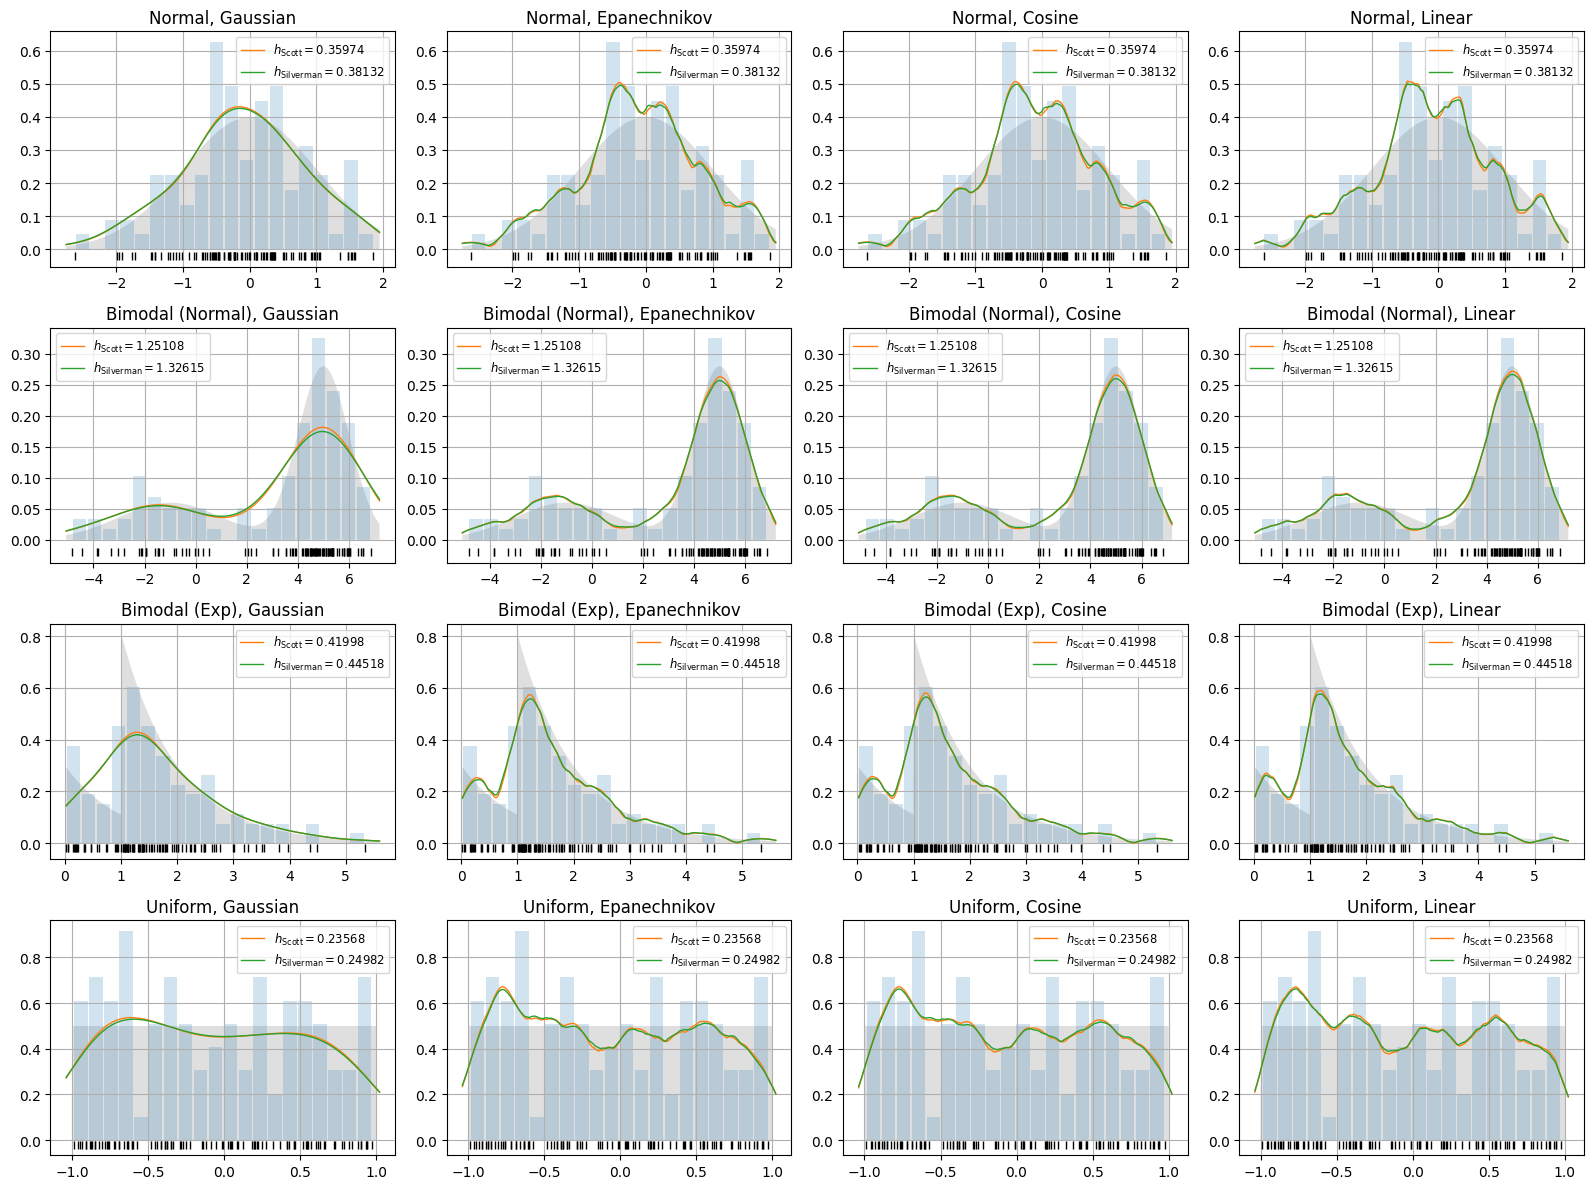

In [9]:
# Experimentation part
data = [
    ('Normal', make_data_normal),
    ('Bimodal (Normal)', make_data_binormal),
    ('Bimodal (Exp)', make_data_exp),
    ('Uniform', make_data_uniform)
]
kernels = [
    ('Gaussian', kernel_selection('gaussian')),
    ('Epanechnikov', kernel_selection('epanechnikov')),
    ('Cosine', kernel_selection('cosine')),
    ('Linear', kernel_selection('linear'))
]
bw_algorithms = [
    ('Scott', bw_scott),
    ('Silverman', bw_silverman)
]
mses = []

def run_kde(ax, data, kernel):
    x, dist = data[1]()
    x_plot = np.linspace(np.min(x) * 1.05, np.max(x) * 1.05, 1000)
    ax.grid(True)
    ax.fill_between(x_plot, dist(x_plot), fc='silver', alpha=0.5)
    ax.plot(x, np.full_like(x, -0.02), '|k', markeredgewidth=1)
    ax.hist(x, density=True, alpha=0.2, bins=20, rwidth=0.9)
    for bw in bw_algorithms:
        h = bw[1](x)
        x_kde = kde(x, kernel[1], h=h, x=x_plot)
        mse = np.mean((dist(x_plot) - x_kde) ** 2)
        mses.append({
            'data': data[0],
            'kernel': kernel[0],
            'bw_algorithm': bw[0],
            'h': round(h, 5),
            'mse': round(mse * 1000, 5),
        })
        ax.plot(x_plot, x_kde, linewidth=1, label='$h_{\mathrm{' + bw[0] + '}} = ' + str(round(h, 5)) + '$')
    ax.legend(loc='best', fontsize='small')
    ax.set_title(f'{data[0]}, {kernel[0]}')

fig, axs = plt.subplots(len(data), len(kernels), figsize=(16, 12))
for i, d in enumerate(data):
    for j, k in enumerate(kernels):
        run_kde(axs[i, j], d, k)
    for bw in bw_algorithms:
        avg_h = np.mean([m['h'] for m in mses if m['data'] == d[0] and m['bw_algorithm'] == bw[0]])
        avg_mse = np.mean([m['mse'] for m in mses if m['data'] == d[0] and m['bw_algorithm'] == bw[0]])
        mses.append({
            'data': d[0],
            'kernel': '-',
            'bw_algorithm': bw[0],
            'h': round(avg_h, 5),
            'mse': round(avg_mse, 5),
        })

fig.tight_layout()


What is the best pair disctibution-kernel?

In [10]:
# Find the best distribution-kernel pair
best_pair = min(mses, key=lambda x: x['mse'])
print("\nBest distribution-kernel pair based on MSE:")
print(best_pair)


Best distribution-kernel pair based on MSE:
{'data': 'Bimodal (Normal)', 'kernel': 'Linear', 'bw_algorithm': 'Scott', 'h': 1.25108, 'mse': 0.08542}


In [11]:
# Assert statements for verification
def assert_statements():
    # Check if kernels are defined correctly
    for k_name in ['gaussian', 'epanechnikov', 'cosine', 'linear']:
        assert kernel_selection(k_name) is not None, f"Kernel function {k_name} should be defined"

    # Check if data is not empty
    for d_name, d_func in data:
        x, _ = d_func()
        assert len(x) > 0, f"Data for {d_name} should not be empty"

    # Check if bandwidths are positive
    for bw in bw_algorithms:
        for d_name, d_func in data:
            x, _ = d_func()
            h = bw[1](x)
            assert h > 0, f"Bandwidth for {d_name} using {bw[0]} should be positive"

    # Check if MSEs are reasonable
    for mse in mses:
        assert mse['mse'] >= 0, "MSE should be non-negative"

assert_statements()

### Exersice 2:

You have a dataset containing Apple's (AAPL) stock data for the last several years. Your task is to

1. check how well the default kde function from scikit learn fits your data;

2. run a greed search for 2 or more parameters in KDE to find the optimal ones;

3. check how well the found KDE fits your data;

4. set all the necessary titles, legends and axes' limits to have figures as given ones.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# Load the data
stocks = pd.read_csv('finance-charts-apple.csv').loc[:, ['Date', 'AAPL.Open', 'AAPL.High', 'AAPL.Low', 'AAPL.Close', 'AAPL.Volume']]
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks.set_index(stocks['Date'], inplace=True)


stocks.head(5)

,Date,AAPL.Open,AAPL.High,AAPL.Low,AAPL.Close,AAPL.Volume
Date,,,,,,
2015-02-17,2015-02-17,127.489998,128.880005,126.919998,127.830002,63152400
2015-02-18,2015-02-18,127.629997,128.779999,127.449997,128.720001,44891700
2015-02-19,2015-02-19,128.479996,129.029999,128.330002,128.449997,37362400
2015-02-20,2015-02-20,128.619995,129.500000,128.050003,129.500000,48948400
2015-02-23,2015-02-23,130.020004,133.000000,129.660004,133.000000,70974100


In [13]:
#calculating the daily returns
stocks['pct_change'] = stocks['AAPL.Close'].pct_change()
stocks.dropna(inplace=True)
stocks.head(5)

,Date,AAPL.Open,AAPL.High,AAPL.Low,AAPL.Close,AAPL.Volume,pct_change
Date,,,,,,,
2015-02-18,2015-02-18,127.629997,128.779999,127.449997,128.720001,44891700,0.006962
2015-02-19,2015-02-19,128.479996,129.029999,128.330002,128.449997,37362400,-0.002098
2015-02-20,2015-02-20,128.619995,129.500000,128.050003,129.500000,48948400,0.008174
2015-02-23,2015-02-23,130.020004,133.000000,129.660004,133.000000,70974100,0.027027
2015-02-24,2015-02-24,132.940002,133.600006,131.169998,132.169998,69228100,-0.006241


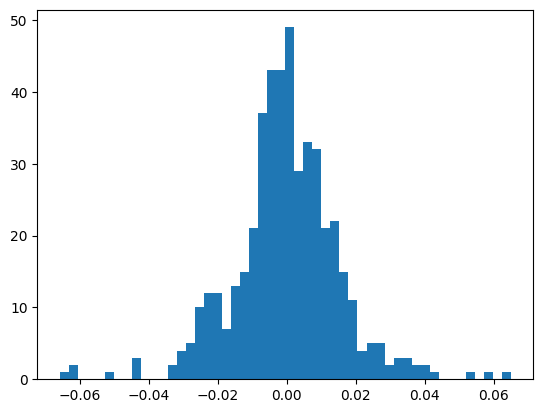

In [14]:
#selection of daily returns only for 2015-2016 year (the data you need work with)
train = stocks['2015':'2016']
train_returns = train['pct_change']
plt.hist(train_returns, bins=50);

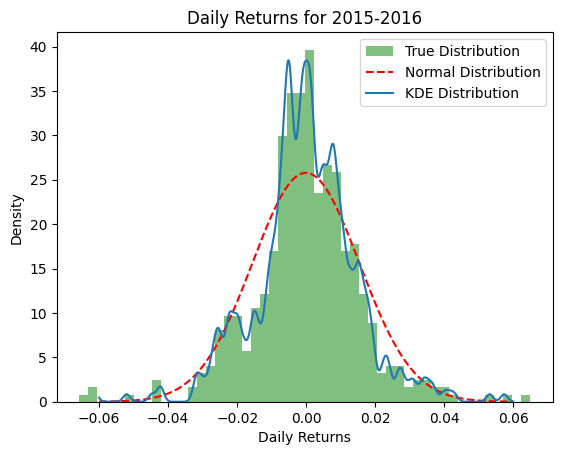

In [15]:
# Solution 2.1: KDE fitting
def normal_pdf(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

train_returns_arr = np.array(train_returns).reshape(-1, 1)
kde = KernelDensity(bandwidth=0.001).fit(train_returns_arr)

mu, sigma = train_returns.mean(), train_returns.std()
xs = np.linspace(-0.06, 0.06, 1000)

# Check what kde scikit-learn function returns
log_probs = kde.score_samples(xs.reshape(-1, 1))
kde_pdf = np.exp(log_probs)

# Plot histogram of train data's true distribution
plt.hist(train_returns, bins=50, density=True, alpha=0.5, color='green', label='True Distribution')

# Plot a normal curve
plt.plot(xs, normal_pdf(xs, mu, sigma), color='red', linestyle='--', label='Normal Distribution')

# Plot a KDE curve
plt.plot(xs, kde_pdf, label='KDE Distribution')

plt.title('Daily Returns for 2015-2016')
plt.ylabel('Density')
plt.xlabel('Daily Returns')
plt.legend(loc='best')
plt.show()
None

The fitted distribution is not precise. Let's optimize the parameters!

In [16]:
#solution 2.2
from sklearn.model_selection import GridSearchCV

#to-do: make a dictionary of all the parameters you want to check
params = {'bandwidth': np.linspace(0.0001, 0.01, 50)}

grid = GridSearchCV(KernelDensity(),
                    param_grid=params,
                    cv=20,
                    n_jobs=-1).fit(train_returns_arr)

grid.best_params_




{'bandwidth': 0.004140816326530613}

In [18]:
# grid.best_params_ assert statement

assert grid.best_params_ is not None, "GridSearchCV should return the best parameters"

# Check if the best bandwidth is positive
assert grid.best_params_['bandwidth'] > 0, "Bandwidth should be positive"


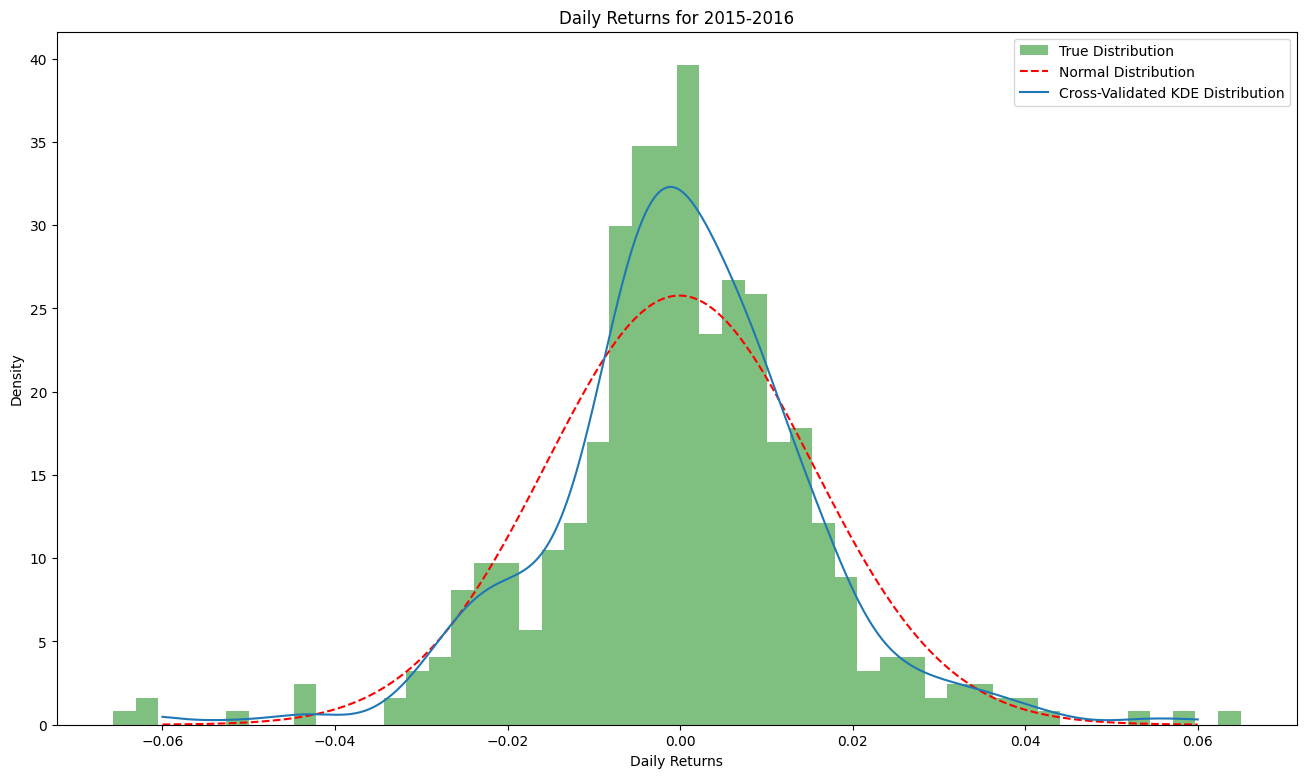

In [ ]:

# Solution 2.3: Best KDE fitting
best_kde = KernelDensity(bandwidth=grid.best_params_['bandwidth']).fit(train_returns_arr)

log_probs = best_kde.score_samples(xs.reshape(-1, 1))
best_kde_pdf = np.exp(log_probs)

plt.subplots(figsize=(16, 9))

# Plot histogram of train data's true distribution
plt.hist(train_returns, bins=50, density=True, alpha=0.5, color='green', label='True Distribution')

# Plot a normal curve
plt.plot(xs, normal_pdf(xs, mu, sigma), color='red', linestyle='--', label='Normal Distribution')

# Plot a cross-validated KDE curve
plt.plot(xs, best_kde_pdf, label='Cross-Validated KDE Distribution')

plt.title('Daily Returns for 2015-2016')
plt.ylabel('Density')
plt.xlabel('Daily Returns')
plt.legend(loc='best')
plt.show()

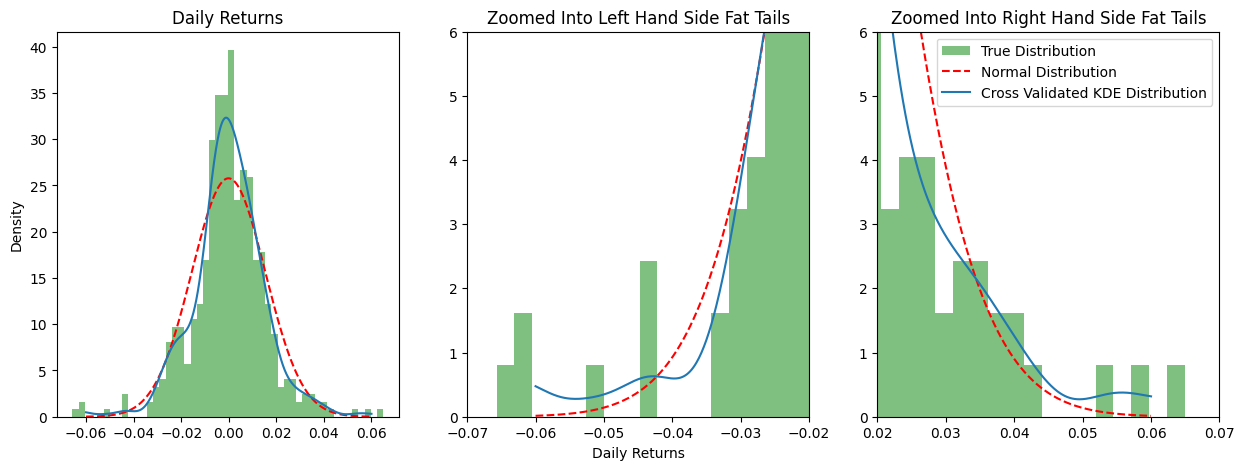

In [ ]:
#solution 2.4
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for i in range(3):
    ax[i].hist(train_returns, density=True, color='green', bins=50, alpha=0.5,
               histtype='stepfilled', label='True Distribution')
    ax[i].plot(xs, normal_pdf(xs, mu, sigma), color='red',
         linestyle='--', label='Normal Distribution')
    ax[i].plot(xs, best_kde_pdf, label='Cross Validated KDE Distribution')

#to-do: set labels, titles, and limits for your plots
#your code is here for to-do





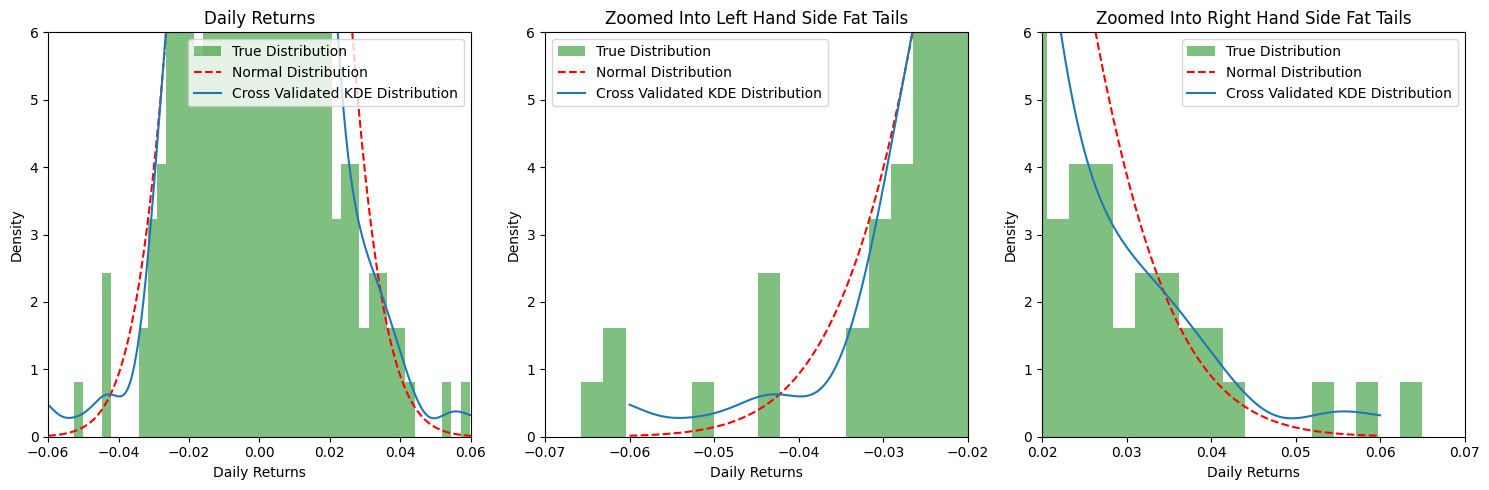

In [ ]:
# Solution 2.4: Final plots with titles, legends, and limits
#solution 2.4
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for i in range(3):
    ax[i].hist(train_returns, density=True, color='green', bins=50, alpha=0.5,
               histtype='stepfilled', label='True Distribution')
    ax[i].plot(xs, normal_pdf(xs, mu, sigma), color='red',
         linestyle='--', label='Normal Distribution')
    ax[i].plot(xs, best_kde_pdf, label='Cross Validated KDE Distribution')
    ax[i].set_xlim([-0.06, 0.06])
    ax[i].set_ylim([0, 6])
    ax[i].set_xlabel('Daily Returns')
    ax[i].set_ylabel('Density')
    ax[i].legend(loc='best')
    if i == 0:
        ax[i].set_title('Daily Returns')
    elif i == 1:
        ax[i].set_xlim([-0.07, -0.02])
        ax[i].set_title('Zoomed Into Left Hand Side Fat Tails')
    elif i == 2:
        ax[i].set_xlim([0.02, 0.07])
        ax[i].set_title('Zoomed Into Right Hand Side Fat Tails')

plt.tight_layout()
